# Ноутбук для анализа данных инстаграмма 

- задача найти потенциальных клиентов для проекта cubeek.ru
- подготовить список на тестовую рассылку
- кластеризовать людей на наших потенциальных клиентов, клиентов других сервисов и не нашу ЦА

## Требования к потенциальным клиентам

- они должны быть русскоязычные 
- они должны быть самозанятыми, специалистами, инфлюенсерами или малым бизнесом  

In [28]:
import pandas as pd
import json
import pickle
import re
import langdetect

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

## Подготовка данных

- выбрать русских
- удалить малоинформативные колонки
- создать и почистить признаки

In [29]:
class Lang():
    def __init__(self, only_ru=True):
        self.only_ru = only_ru
    
    def _find_ru(self, text):
        if len(re.findall(r'[А-я]+', text)) > 0:
            return 'ru'
        elif self.only_ru:
            return 'other'
        else:
            try:
                return langdetect.detect(text)
            except langdetect.lang_detect_exception.LangDetectException:
                return 'unknown'
    
    def detect(self, text):
        if type(text) == pd.core.series.Series:
            return text.apply(lambda x: self._find_ru(x))
        if type(text) == 'str':
            return self._find_ru(text)
        else:
             print("Exception")
        

In [30]:
class TargetDetector():
    
    def __init__(self):
        pass
    
    def _check(self, text):
        if str(text) != 'nan':
            return True
        return False
    
    def _len(self, bio):
        if self._check(bio):
            return len(bio)
        return 0
    
    def _sigmas_rule(self, x):
        bottom = x.mean() - 3 * x.std()
        top = x.mean() + 3 * x.std()
        x.loc[(x<bottom)] = bottom
        x.loc[(x>top)] = top
        return x
    
        

In [31]:
pd.set_option('display.max_columns', None)

In [32]:
df = pd.concat([
    pd.read_csv('users/users.csv', on_bad_lines='skip', nrows=2170000),
    pd.read_csv('users/users2.csv', on_bad_lines='skip'),
    pd.read_csv('users/users3.csv', on_bad_lines='skip', encoding='utf8'),
])

/var/folders/6p/6f5lb1_d589gj7g7ym410nc00000gn/T/ipykernel_12904/1960017463.py:2: DtypeWarning: Columns (9,11,18,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('users/users.csv', on_bad_lines='skip', nrows=2170000),
/var/folders/6p/6f5lb1_d589gj7g7ym410nc00000gn/T/ipykernel_12904/1960017463.py:3: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('users/users2.csv', on_bad_lines='skip'),
/var/folders/6p/6f5lb1_d589gj7g7ym410nc00000gn/T/ipykernel_12904/1960017463.py:4: DtypeWarning: Columns (11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('users/users3.csv', on_bad_lines='skip', encoding='utf8'),


In [33]:
df['has_chaining'] = df['has_chaining'].replace({'TRUE': True, 'FALSE': False})

In [34]:
df.head()

,updated_at,pk,username,full_name,is_private,profile_pic_url,profile_pic_id,is_verified,has_anonymous_profile_picture,media_count,geo_media_count,follower_count,following_count,following_tag_count,biography,external_url,total_igtv_videos,total_ar_effects,usertags_count,has_chaining,fb_page_call_to_action_id,address_street,business_contact_method,city_name,contact_phone_number,is_call_to_action_enabled,latitude,longitude,public_email,public_phone_country_code,public_phone_number,zip,instagram_location_id,is_business,account_type
0,2019-10-07 12:03:25.792131,6.573909e+09,k.x.y_rider24,Robin Farge,True,https://instagram.ftun4-1.fna.fbcdn.net/vp/567...,2115722383873785705_6573908746,False,False,6.0,0.0,234.0,395.0,4.0,14 yrs vineuil💉🔥collège ndv BIKE LIFE les meil...,NaN,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
1,2019-10-07 12:03:26.497576,3.426365e+09,soumia_merrouchi,S O M I A 🌸,True,https://instagram.faru1-1.fna.fbcdn.net/vp/485...,2145105756370619601_3426365033,False,False,157.0,0.0,2366.0,496.0,0.0,08/09/1999🍭 🇲🇦سمية 🇲🇦,http://elliemerr.saraha.online/,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
2,2019-10-07 12:03:26.617852,4.823769e+09,dihernandezp,Diego Hernández,False,https://scontent-mxp1-1.cdninstagram.com/vp/76...,2143873106879251557_4823768644,False,False,95.0,NaN,351.0,919.0,0.0,🔹Guaireño - UCVista 🔸Creo que lo mejor que pod...,NaN,0.0,0.0,23.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
3,2019-10-07 12:03:26.718347,1.878387e+10,sanjay_8646,sanjay Venam,False,https://scontent-waw1-1.cdninstagram.com/vp/f8...,2144478310806029747_18783865347,False,False,5.0,0.0,55.0,80.0,0.0,NaN,NaN,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
4,2019-10-07 12:03:26.795294,1.067227e+09,baglaev_1_,∀ R † ė ₥,False,https://instagram.fbru3-1.fna.fbcdn.net/vp/2d1...,1512635330423191234_1067226933,False,False,396.0,0.0,637.0,408.0,0.0,NaN,NaN,0.0,0.0,135.0,True,NaN,NaN,CALL,NaN,+79687122525,False,0.0,0.0,mr.baglaev@mail.ru,7.0,9.687123e+09,NaN,NaN,True,2.0


In [35]:
df = df.set_index('username')
df = df[df['is_private'] == False]
df = df.drop(['updated_at', 'pk', 'is_private', 'profile_pic_url', 'profile_pic_id', 'is_verified', 
             'has_anonymous_profile_picture', 'address_street', 'latitude', 'longitude',
              'public_phone_country_code', 'public_phone_number', 'zip', 'instagram_location_id',
              'business_contact_method', 'fb_page_call_to_action_id', 'total_ar_effects'
              ], axis=1)

In [36]:
text_feats = ['biography', 'full_name']
df[text_feats] = df[text_feats].astype('str')

In [37]:
lang = Lang()
df['lang'] = lang.detect(df['biography'])
df['name_lang'] = lang.detect(df['full_name'])

In [38]:
print('Rate of rus:', len(df[(df['lang'] == 'ru')|(df['name_lang'] == 'ru')])/len(df))

Rate of rus: 0.32104761050367486


In [39]:
df=df[(df['lang'] == 'ru')|(df['name_lang'] == 'ru')]

In [40]:
# df['target'] = df['address_street'].apply(lambda x: 'small_business' if str(x) != 'nan' else 'other')

In [41]:
td = TargetDetector()

In [42]:
check_features = ['public_email', 'contact_phone_number', 'city_name', 'external_url']
for feat in check_features:
    df['has_'+feat] = df[feat].apply(lambda x: td._check(x))

In [43]:
df['len_bio'] = df['biography'].apply(lambda x: td._len(x))

In [44]:
features = [
    'media_count', 
#     'geo_media_count', 
    'follower_count', 'following_tag_count',
    'total_igtv_videos', 'usertags_count', 'has_chaining',
#     'is_call_to_action_enabled', 
    'is_business', 
#     'has_external_url', it's like tarhet
    'has_city_name', 'has_contact_phone_number', 'has_public_email', 'len_bio'
           ]

In [45]:
competitors = 'linktr|tilda|taplink|mssg|meconnect|hipolink|ylink|avatap'
df['competitors'] = 0
df.loc[(df['external_url'].str.contains(competitors))&(df['external_url'].str != 'nan'), 'competitors'] = 1

In [46]:
df[features] = df[features].fillna(0).astype('float')

In [57]:
df['account_type'] = df['account_type'].astype('str')

In [47]:
for feat in ['media_count', 'follower_count', 'following_tag_count', 'total_igtv_videos', 'usertags_count']:
    df[feat] = td._sigmas_rule(df[feat])

/var/folders/6p/6f5lb1_d589gj7g7ym410nc00000gn/T/ipykernel_12904/2882102663.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.loc[(x<bottom)] = bottom
/var/folders/6p/6f5lb1_d589gj7g7ym410nc00000gn/T/ipykernel_12904/2882102663.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.loc[(x>top)] = top


## Сравнение клиентов конкурентов и остальных пользователей

In [48]:
df_plt = pd.concat([df[df['competitors']==0].sample(len(df[df['competitors']==1])), df[df['competitors']==1]])

media_count


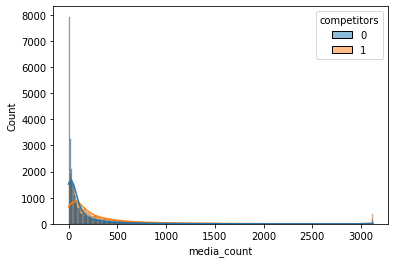

follower_count


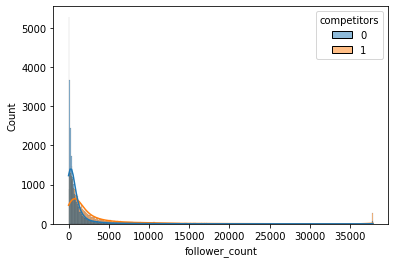

following_tag_count


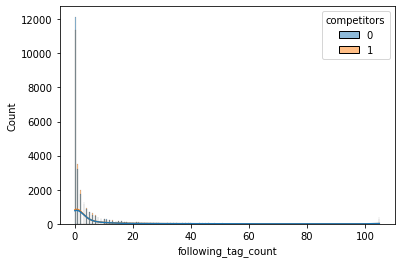

total_igtv_videos


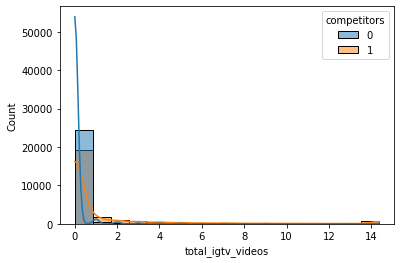

usertags_count


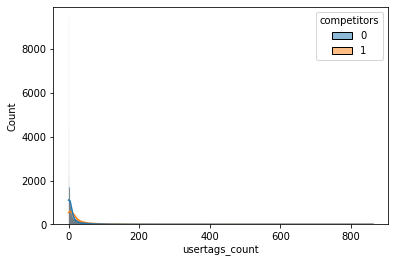

has_chaining


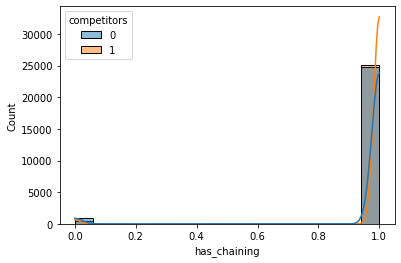

is_business


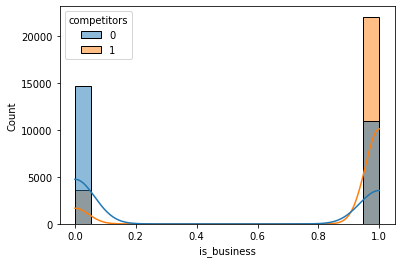

has_city_name


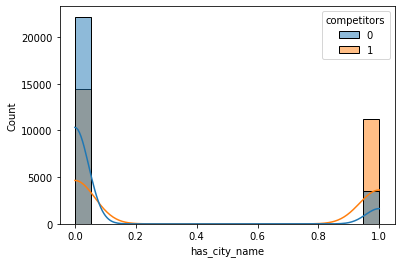

has_contact_phone_number


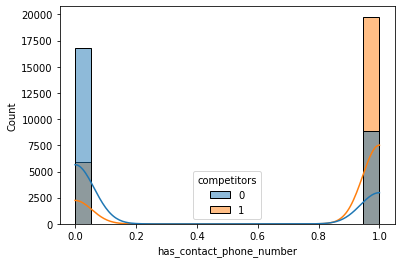

has_public_email


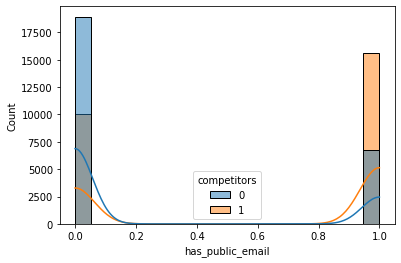

len_bio


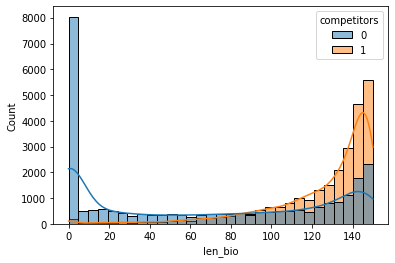

In [49]:
for i, feat in enumerate(features):
    print(feat)
#     plt.figure(i)
    plt.clf()
    sns.histplot(data=df_plt, x=feat, hue='competitors', kde=True)
    plt.show()

## Поиск похожих клиентов на клиентов конкурентов

### nltk

In [6]:
from nltk.tokenize import word_tokenize

from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 
stemmer.stem("Василий")

'васил'

In [16]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/artemsteshenko/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemsteshenko/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
from nltk.corpus import stopwords

In [25]:
def prep(text):
    text = word_tokenize(text, language='russian')
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('russian')]
    return ' '.join(text)

In [50]:
df_plt['biography'] = df_plt['biography'].apply(lambda x: prep(x))

### Catboost

In [51]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split


In [52]:
len(df)

880353

In [53]:
X = df_plt[features+['biography', 'full_name', 'account_type']]
y = df_plt['competitors']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y.values,test_size=0.3)

In [56]:
cat_features=['account_type']
text_features=['biography', 'full_name']

train_pool = Pool(
    X_train, 
    y_train, 
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test, 
    y_test,
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(X_train)
)

catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.01,
    'eval_metric': 'AUC',
#     'task_type': 'GPU',
    'early_stopping_rounds': 50,
    'use_best_model': True,
    'verbose': 50,

}
# clas_weight = [5,4]
model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.8217829	best: 0.8217829 (0)	total: 232ms	remaining: 11m 34s
50:	test: 0.8541387	best: 0.8541387 (50)	total: 7.96s	remaining: 7m 40s
100:	test: 0.8582111	best: 0.8582712 (99)	total: 15.5s	remaining: 7m 25s
150:	test: 0.8625211	best: 0.8625211 (150)	total: 23s	remaining: 7m 14s
200:	test: 0.8654751	best: 0.8654751 (200)	total: 30.3s	remaining: 7m 2s
250:	test: 0.8679937	best: 0.8679937 (250)	total: 38.3s	remaining: 6m 59s
300:	test: 0.8700752	best: 0.8700752 (300)	total: 45.7s	remaining: 6m 50s
350:	test: 0.8717361	best: 0.8717361 (350)	total: 53s	remaining: 6m 40s
400:	test: 0.8731336	best: 0.8731336 (400)	total: 1m	remaining: 6m 31s
450:	test: 0.8741857	best: 0.8741857 (450)	total: 1m 7s	remaining: 6m 22s
500:	test: 0.8752712	best: 0.8752712 (500)	total: 1m 14s	remaining: 6m 13s
550:	test: 0.8761534	best: 0.8761534 (550)	total: 1m 22s	remaining: 6m 5s
600:	test: 0.8769677	best: 0.8769677 (600)	total: 1m 29s	remaining: 5m 57s
650:	test: 0.8778126	best: 0.8778126 (650)	total: 

In [60]:
feature_imp = pd.DataFrame()
feature_imp['feature_importance'] = model.get_feature_importance()
feature_imp['features'] = list(X_train)

<AxesSubplot: xlabel='feature_importance', ylabel='features'>

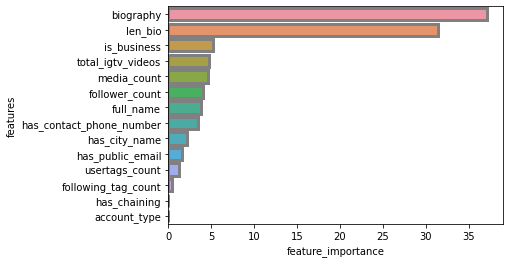

In [68]:
sns.color_palette("light:#5A9", as_cmap=True)
sns.barplot(data=feature_imp.sort_values('feature_importance', ascending=False), x="feature_importance", y="features",
            errorbar=("pi", 50), capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5")

In [59]:
list(X_train)

['media_count',
 'follower_count',
 'following_tag_count',
 'total_igtv_videos',
 'usertags_count',
 'has_chaining',
 'is_business',
 'has_city_name',
 'has_contact_phone_number',
 'has_public_email',
 'len_bio',
 'biography',
 'full_name',
 'account_type']

In [75]:
model.predict(df[list(X_train)])

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
df['cat_pred'] = model.predict(df[list(X_train)])

[0.98977517 0.00979637]


<AxesSubplot: xlabel='0', ylabel='1'>

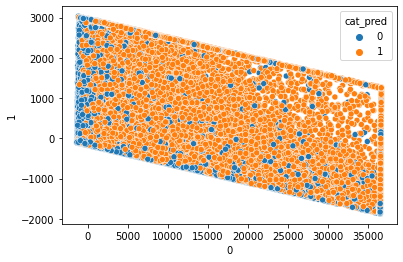

In [89]:
pca = PCA(n_components=2)
df2 = pca.fit_transform(df[features])
print(pca.explained_variance_ratio_)
df2 = pd.DataFrame(df2, index=df.index)
df2['cat_pred'] = df['cat_pred']
sns.scatterplot(data=df2, x=0, y=1, hue='cat_pred')

In [77]:
df['cat_pred'].value_counts()

0    620994
1    259359
Name: cat_pred, dtype: int64

In [80]:
df[df['cat_pred'] == 1]['has_contact_phone_number'].value_counts()

1.0    214122
0.0     45237
Name: has_contact_phone_number, dtype: int64

In [98]:
df[(df['cat_pred'] == 1)&(df['is_business'] == 0)][:60]

,full_name,media_count,geo_media_count,follower_count,following_count,following_tag_count,biography,external_url,total_igtv_videos,usertags_count,has_chaining,city_name,contact_phone_number,is_call_to_action_enabled,public_email,is_business,account_type,lang,name_lang,has_public_email,has_contact_phone_number,has_city_name,has_external_url,len_bio,competitors,cat_pred
username,,,,,,,,,,,,,,,,,,,,,,,,,,
gyro_school,🏅🏆🎖Школа трикинга Gyro,47.000000,0.0,4571.000000,4243.0,0.0,🏅🏆🎖Первая школа в Санкт-Петербурге Запишись на...,NaN,0.000000,25.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,ru,ru,0.0,0.0,0.0,False,124.0,0,1
chokkaev_95,Тархан Чоккаев,213.000000,0.0,6339.000000,313.0,0.0,Бено☝🏻 Ведущий🎙 Спасатель МЧС🚒 Студент #СГЮА ...,http://vk.com/tchokkaev,2.000000,117.0,1.0,NaN,+79899309431,False,tchokkaev955@mail.ru,0.0,3.0,ru,ru,1.0,1.0,0.0,True,100.0,0,1
_sinan__a_,🌻SINAN_A🌻,20.000000,0.0,6646.000000,6544.0,0.0,▶____☣Ôwņ ŘúĽÊś☠__ ▶___σиℓу_єиנσу___ ▶__06jun_...,NaN,0.000000,58.0,1.0,NaN,NaN,False,sinan2462003@gmail.com,0.0,3.0,ru,other,1.0,0.0,0.0,False,135.0,0,1
alyona_raguzina,Алена,1419.000000,0.0,1100.000000,2383.0,6.0,🕧Экономим время на покупках 💯Предоплата. 🌎Артё...,https://api.whatsapp.com/send?phone=79147013653,0.000000,8.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,ru,ru,0.0,0.0,0.0,True,136.0,0,1
liliyanigmatova15,Лилия Нигматова,24.000000,0.0,2055.000000,2726.0,0.0,Счастливая мама👩👩 🍁Амелия ❤ Амина Зарабатыва...,http://lily-nigmatova.businessonlinetop.com/,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,ru,ru,0.0,0.0,0.0,True,141.0,0,1
karat__jewellery,Bakı-MUM(ЦУМ)☎️+994513500009👱,3120.644141,0.0,37852.683545,5586.0,0.0,YALNIZ BIZDƏ ÇOX KEYFIYYƏTLI VƏ SƏRFƏLI QIYMƏT...,http://wa.me/994513500009,3.000000,40.0,1.0,NaN,+994513500009,False,s.s-84@mail.ru,0.0,3.0,other,ru,1.0,1.0,0.0,True,140.0,0,1
mister_olympia_official,Мистер Олимпия,3120.644141,NaN,4973.000000,7485.0,0.0,"🇺🇦 Оф. представитель Malay Tiger, ZPHC, Pharma...",https://t.me/mister_olympia_off,14.373182,5.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,ru,ru,0.0,0.0,0.0,True,145.0,0,1
bobrishevmaksim,🌲🌴СОЧИ🌴БОБРЫШЕВ МАКСИМ🌴🌲🌞🗿,443.000000,0.0,4048.000000,4413.0,2.0,🌎ВЕЛИКИЕ ЛУКИ🌎МАГАДАН🌎ЧИГИЧИНАХ🌎ПРИЙСК ИМЕНИ X...,NaN,14.373182,21.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,ru,ru,0.0,0.0,0.0,False,118.0,0,1
shanezhka.ya,Девушка с лисой на жопе🦊,33.000000,0.0,1922.000000,3716.0,0.0,Здесь пьют чай без сахара ! ! ! ...,NaN,0.000000,0.0,1.0,NaN,NaN,False,leravikulina@yandex.ru,0.0,3.0,ru,ru,1.0,0.0,0.0,False,150.0,0,1


In [96]:
for ind, user in enumerate(df[df['cat_pred'] == 1].index):
    if ind > 300 and ind < 3000:
        print(user)

cheb_dekor21
remont.mobi_i
irinasergeichuk
remmeb24.ru
yulia.pozdeeva
_ainuri_
9.k.60
zakharovaiulia
liya_chls
kristi_botox_lash
gelengik2019
store_bel_fiore_
world_of_women_kzn
crafter_land
susan_mota
thesmile_kazan
viktoriavokrugshum
seanstaro
zdravie21
_ol_tar
nagorrnaya
stepanovanatal
_basharova_rina_dance
aleksandr_chadov
airdecor.msk
domdobra_vernost
sewing_portal
cvety_svetilniki
_kate_brows_
blackberry_rf
md_mazhdad
remont.tehniki.karakol
luboff_photo
mela_verde_wedding
sz_pink_store
alexkorsten
in.starlab.ru
liliyushkin
mini_otel_deluxe
kutuzova.k90
big.mitch.gym
bazanedvigimosti
mary_angel__mary
riofitness_
indira_zhant_makeup
alisa_rax
accept352
margo_besthair
dreamdoors.komdir
moskvekukhniv
dilya_panterra
keratin_botoks_23
by_smirnova_ri
sakvareli.kz
silver_style_gk
gdezerno
moiakisika
morozovanails
modnaya_lavka123
beauty.lash.marina
tui_cosmopolite
_beautyroom_1
rudenko_aleksej
ahalyoka
urakudrasov2656
albina_zholdubaeva
tishin_s
remzona94
yuliyapodolyan_marykay
tolstoy_b

In [97]:
df.to_pickle('df.pickle')